# EE 511 Assignment 2 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [1]:
# Supress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import tools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

tools.check_sklearn_version()

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## \[Step 3\] Load training, validation and testing data

In [2]:
train, valid, test = tools.load_data()

## \[Step 4\] One variable least squares linear regression 

In [3]:
area_label = 'Gr Liv Area'
price_label = 'SalePrice'

area_train = train[area_label].to_numpy()
area_valid = valid[area_label].to_numpy()
area_test = test[area_label].to_numpy()
price_train = train[price_label].to_numpy()
price_valid = valid[price_label].to_numpy()
price_test = test[price_label].to_numpy()

In [4]:
small_model = LinearRegression().fit(area_train.reshape(-1, 1), price_train)

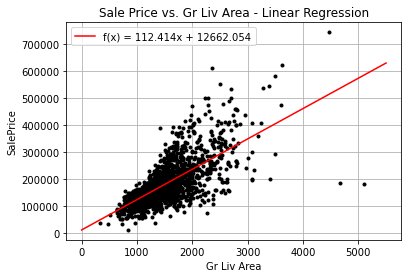

In [5]:
x = np.linspace(0, 5500, 100)
y = small_model.coef_[0] * x + small_model.intercept_

plt.xlabel(area_label)
plt.ylabel(price_label)
plt.plot(area_train, price_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (small_model.coef_[0], small_model.intercept_))
plt.legend()
plt.title('Sale Price vs. Gr Liv Area - Linear Regression')
plt.grid()

In [6]:
price_predicted = small_model.predict(area_valid.reshape(-1, 1))
print('RMSE = $%.2f' % mean_squared_error(price_valid, price_predicted, squared=False))

RMSE = $56299.05


## \[Step 5\] Adding more features to the simple model

In [7]:
train_without_price = train.drop(price_label, 1)
valid_without_price = valid.drop(price_label, 1)
test_without_price = test.drop(price_label, 1)

In [8]:
large_model = LinearRegression().fit(train_without_price, price_train)
pred = large_model.predict(valid_without_price)
print('RMSE = $%.2f' % mean_squared_error(price_valid, pred, squared=False))

RMSE = $26700.24


## \[Step 6\] Adding L1 regularization

In [9]:
# Normalize the data
normalized_train = (train_without_price - train_without_price.mean()) / (train_without_price.std()+0.0000001)
normalized_train[price_label] = price_train
normalized_valid = (valid_without_price - train_without_price.mean()) / (train_without_price.std()+0.0000001)
normalized_valid[price_label] = price_valid
normalized_test = (test_without_price - train_without_price.mean()) / (train_without_price.std()+0.0000001)
normalized_test[price_label] = price_test

In [10]:
# Search for best value of alpha
alphas = np.linspace(50,500,20)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_valid = []
mse_train = []
num_nonzero = []
num_nonzero2 = []
for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha, random_state=77)
    mse_kfold = []
    # Iterate through all folds
    for train_index, test_index in kf.split(normalized_train):
        # Get test and training data from current fold
        kf_train = normalized_train.iloc[train_index]
        kf_test = normalized_train.iloc[test_index]
        kf_train_price = kf_train[price_label].to_numpy()
        kf_train_without_price = kf_train.drop(price_label, 1).to_numpy()
        kf_test_price = kf_test[price_label].to_numpy()
        kf_test_without_price = kf_test.drop(price_label, 1).to_numpy()
        
        
        large_model_lasso.fit(kf_train_without_price, kf_train_price)
        kf_test_pred = large_model_lasso.predict(kf_test_without_price)
        error = mean_squared_error(kf_test_price, kf_test_pred, squared=False)
        mse_kfold.append(error)

    mse_train.append(np.mean(mse_kfold))
    large_model_lasso.fit(normalized_train.drop(price_label, 1), price_train)
    pred_valid = large_model_lasso.predict(normalized_valid.drop(price_label, 1))
    mse_valid.append(mean_squared_error(price_valid, pred_valid, squared=False))
    

# Code for finding number of nonzero coefficients
# num_nonzero.append(np.sum(large_model_lasso.coef_ != 0))

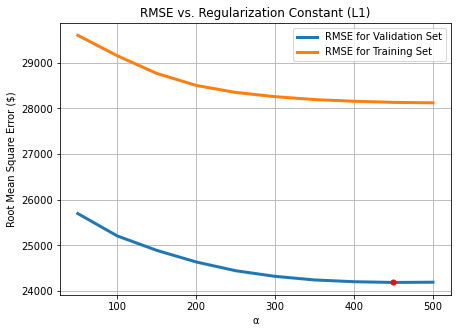

In [11]:
best_alpha = alphas[np.argmin(mse_valid)]
fig1 = plt.figure(figsize=(7,5))
plt.plot(alphas,mse_valid, linewidth=3)
plt.plot(alphas,mse_train, linewidth=3)
plt.plot(best_alpha,np.min(mse_valid),'r.',markersize=10)
plt.legend(['RMSE for Validation Set','RMSE for Training Set'])
plt.xlabel('α')
plt.ylabel('Root Mean Square Error ($)')
plt.title('RMSE vs. Regularization Constant (L1)')
plt.grid()

### Playing around with training and validation sets

In [36]:
# Search for best value of alpha
alphas = np.linspace(50,500,10)

# Split Data Into 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_test_kf = []
mse_train_kf = []
mse_test = []
mse_train = []

for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha, random_state=77)

    mse_test_kf = []
    mse_train_kf = []
    # Iterate through all folds
    for train_index, test_index in kf.split(normalized_train):
        # Get test and training data from current fold
        kf_train = normalized_train.iloc[train_index]
        kf_test = normalized_train.iloc[test_index]
        kf_train_price = kf_train[price_label].to_numpy()
        kf_train_without_price = kf_train.drop(price_label, 1).to_numpy()
        kf_test_price = kf_test[price_label].to_numpy()
        kf_test_without_price = kf_test.drop(price_label, 1).to_numpy()
        
        large_model_lasso.fit(kf_train_without_price, kf_train_price)
        
        # Test on Validation Fold
        kf_test_pred = large_model_lasso.predict(kf_test_without_price)
        error_test = mean_squared_error(kf_test_price, kf_test_pred, squared=False)
        mse_test_kf.append(error_test)
        
        # Test on Training Fold
        kf_train_pred = large_model_lasso.predict(kf_train_without_price)
        error_train = mean_squared_error(kf_train_price, kf_train_pred, squared=False)
        mse_train_kf.append(error_train)
        
    mse_train.append(np.mean(mse_kfold))
    mse_test.append(np.mean(mse_test_kf))    

# Code for finding number of nonzero coefficients
# num_nonzero.append(np.sum(large_model_lasso.coef_ != 0))

/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/pyt

In [39]:
print(mse_train)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [12]:
# Train Model with optimum alpha
large_model_lasso = Lasso(alpha=best_alpha)
large_model_lasso.fit(normalized_train.drop(price_label, 1), price_train)

Lasso(alpha=450.0)

Overfitting occurs when the model trains specifically for the training set and gets worse at generalizing. <br>
This graph can be used to detect overfitting. If the training error continues to decrease as the validation error increases, then that can suggest that the model is overfitting to the data and not doing as good of a job generalizing with all kinds of data.

## \[Step 6\] Adding L1 regularization - no fold for debug

Data needs to be normalized (above)

In [13]:
# Search for best value of alpha
alphas = np.linspace(0.01,500,20)
rmse_valid = []
rmse_train = []
for alpha in alphas:
    train_price = normalized_train[price_label].to_numpy()
    train_without_price = normalized_train.drop(price_label, 1).to_numpy()
    valid_price = normalized_valid[price_label].to_numpy()
    valid_without_price = normalized_valid.drop(price_label, 1).to_numpy()
    
    
    large_model_lasso = Lasso(alpha=alpha)
    large_model_lasso.fit(train_without_price, train_price)
    pred_valid = large_model_lasso.predict(valid_without_price)
    pred_train = large_model_lasso.predict(train_without_price)
    
    rmse_valid.append(mean_squared_error(valid_price, pred_valid, squared=False))
    rmse_train.append(mean_squared_error(train_price, pred_train, squared=False))

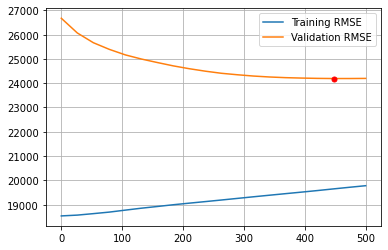

In [14]:
plt.plot(alphas,rmse_train)
plt.plot(alphas,rmse_valid)
plt.plot(alphas[np.argmin(rmse_valid)],np.min(rmse_valid),'r.',markersize=10)
plt.legend(['Training RMSE','Validation RMSE'])
plt.grid()

## \[Step 7\] Testing the Models

### Single Variable Model

In [20]:
pred_test = small_model.predict(area_test.reshape(-1, 1))
rmse_small_model = mean_squared_error(pred_test, price_test, squared=False)
print('RMSE for Simple Model: $%.2f' % rmse_small_model)

RMSE for Simple Model: $55457.72


### Multiple Variables - No Regularization

In [21]:
test_without_price = test.drop(price_label, 1).to_numpy()
pred = large_model.predict(test_without_price)
print('RMSE for multivariate model: $%.2f' % mean_squared_error(price_test, pred, squared=False))

RMSE for multivariate model: $36034.59


### Multiple Variables with optimum L1 Regularization

In [21]:
pred_test = large_model_lasso.predict(normalized_test.drop(price_label, 1))
print('RMSE for multivariate model with L1 regularization: $%.2f' % mean_squared_error(price_test, pred_test, squared=False))

RMSE for multivariate model with L1 regularization: $34004.94


### Summary of Testing Results
| Model | RMSE on Validation | RMSE on Testing |
| :- | -: | -: |
| Single Variable | $56,299.05 | $55,457.72 |
| Multi Variable | $26,700.24 | $36,034.59 |
| L1 Regularization| $24,191.66 | $34,024.06 |